# **Introduction to the Project**

Welcome to an exciting journey into the world of deep learning and flower classification using Tensor Processing Units (TPUs)! In this project, we'll delve into the fascinating realm of neural networks, leveraging the power of TPUs to build an efficient and accurate flower image classifier. Classifying flowers might seem like a simple task for us humans, but teaching a machine to recognize and distinguish between different floral species involves complex computations and sophisticated algorithms.

To tackle this [challenge](https://www.kaggle.com/competitions/tpu-getting-started/overview), we'll be harnessing the incredible computational capabilities of TPUs. Tensor Processing Units are specialized hardware accelerators designed by Google to handle the intense computations required for machine learning tasks.


![TPU Processing Unit](https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Tensor_Processing_Unit_3.0.jpg/330px-Tensor_Processing_Unit_3.0.jpg)


By utilizing TPUs, we can significantly speed up the training process of our neural network, making our flower classifier not only accurate but also efficient.

Throughout this interactive guide, we'll cover every step of the process, from setting up the development environment in [Kaggle](http://www.kaggle.com) to experimenting with various neural network architectures.

The Classification task needs the following key libraries offered by python programming language.  

#  **Libraries**

In [1]:
import math, re, os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report

**Setting Running Strategy (TPU)**

In [2]:
# Detect TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
!mkdir -p /root/.kaggle

In [4]:
!cp /kaggle/input/Json file/kaggle.json /root/.kaggle/

cp: cannot stat '/kaggle/input/Json': No such file or directory
cp: cannot stat 'file/kaggle.json': No such file or directory


# **Loading the Flower Dataset**

THe project dataset is provided as an open-source challenge but to use it in this project we have to use KaggleAPI therefore requiring setting up a Token-based Authentication key that represented that we have accepted the challenge. Without the secret key, one cannot be able to use the KaggleAPI either.

In [6]:
from kaggle.api.kaggle_api_extended import KaggleApi

GCS_DS_PATH = '/kaggle/input/tpu-getting-started'
print(GCS_DS_PATH)

/kaggle/input/tpu-getting-started


# **Exploring the Dataset**

Exploring the flower dataset was a crucial step in the data mining project. It served important purposes that contributed to the overall success of your project:

* **Understanding the Data Structure**: Exploring the dataset helped in gaining a fundamental understanding of the structure and format of the data. 
* **Label Distribution:** For the classification task, exploring the distribution of labels (flower classes in this case) was considered to be essential. 

**Apply the Helper functions to explore tfrecord files in the Flower Dataset**

In [7]:
IMAGE_SIZE = [512, 512]
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [8]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


From the above Output:

**Training Images: 12,753**

* These are the images that will be used to train a machine learning model. During the training phase, the model learns patterns and relationships in the data to make predictions. The training dataset typically includes labeled examples, meaning each image is associated with a corresponding label or category (e.g., types of flowers in a flower classification task).

**Validation Images: 3,712**

* This subset of the dataset is reserved for validation purposes. After training the model on the training images, it needs to be evaluated on data it has never seen before to assess its generalization performance. The validation dataset helps in tuning hyperparameters, preventing overfitting, and making adjustments to the model architecture.

**Unlabeled Test Images: 7,382**

* These images are part of the dataset but do not have associated labels. They are typically used for the final evaluation of the trained model's performance. The model makes predictions on these unlabeled test images, and the predictions can be compared to the true labels (if available) to assess the model's accuracy.

In [9]:
# Define the batch size. It will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [10]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
Training data label examples: [ 48  48 102 ...  67  67  24]


From the above, the shapes represent the dimensions of the training data batches. Each line corresponds to a batch of training data. The format is (batch_size, height, width, channels), where:
* batch_size: The number of examples (images) in each batch.
* height: The height of each image.
* width: The width of each image.
* channels: The number of color channels in each image (e.g., 3 for RGB images).

In [11]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
Test data IDs: ['8c102e395' '9f6708c0b' 'cbb2dd81a' ... '246798d36' '2eb1d2313' '9679190dd']


In [13]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

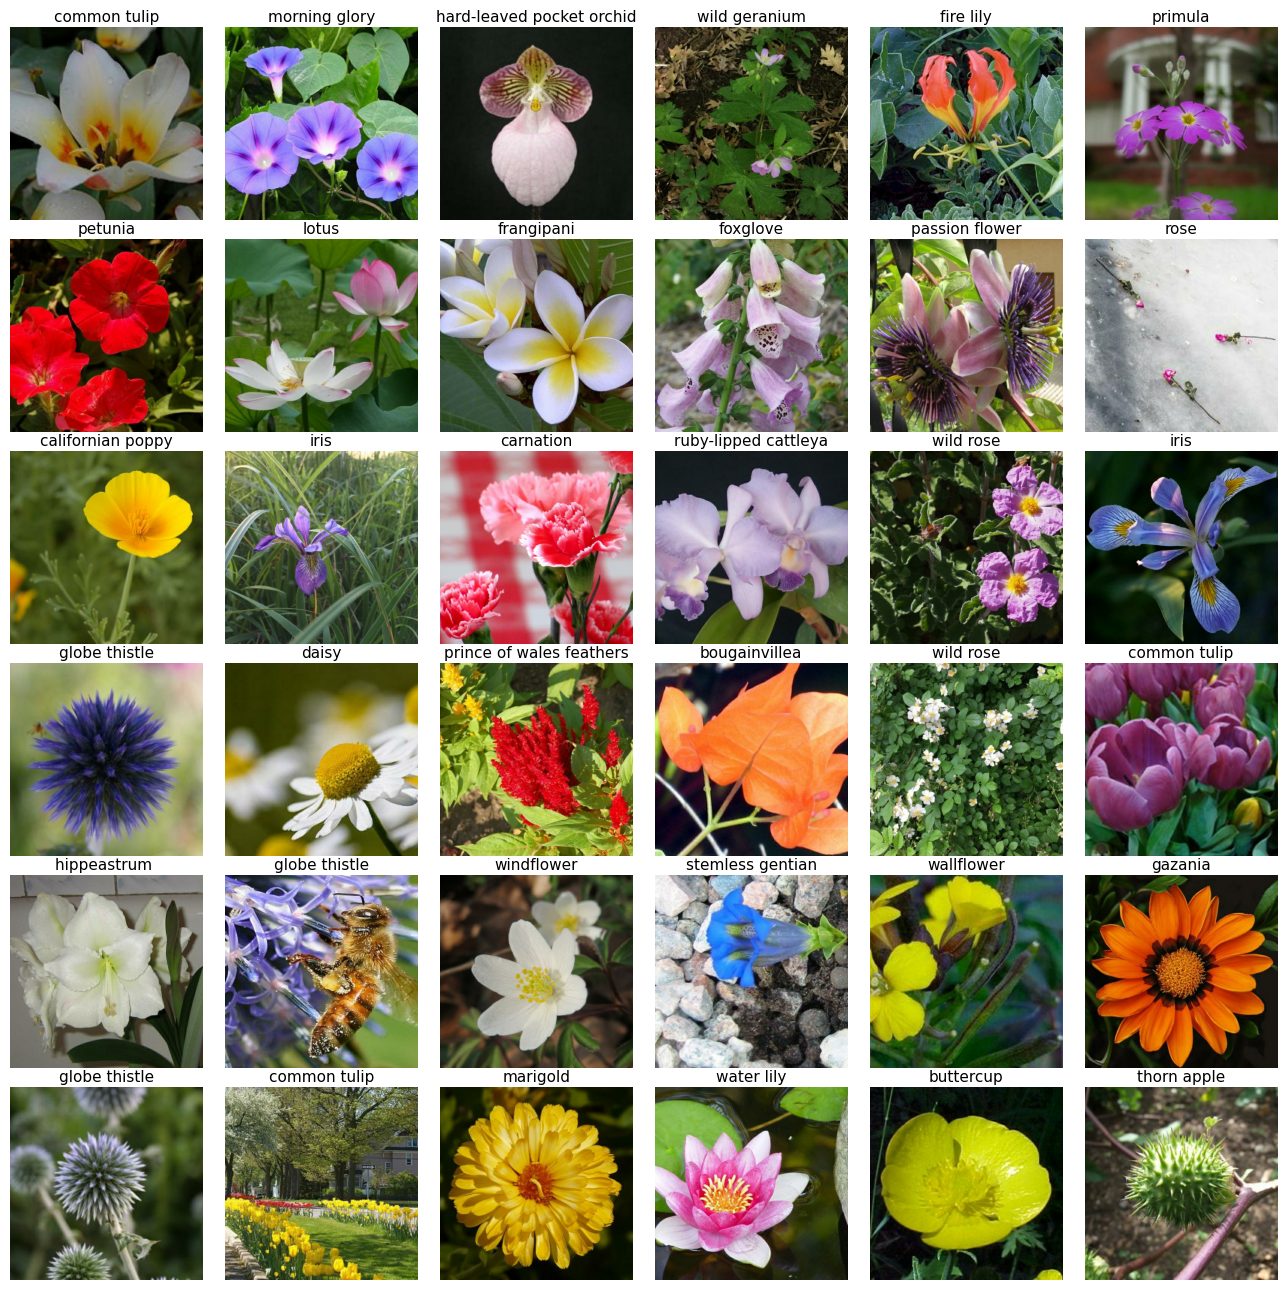

In [14]:
ds_iter = iter(ds_train.unbatch().batch(40))
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

# **Modeling**

This task used a **Convolutional Neural Network (CNN)** model for the image classification

Its architecture is as follows:

**Input Layer**: The model takes as input images with a shape of (224, 224, 3), where 224 is the height and width, and 3 represents the three color channels (RGB). This input shape is common in image classification tasks.

**Convolutional Layers:** Three convolutional layers (Conv2D) are used for feature extraction. Each convolutional layer is followed by a max-pooling layer (MaxPooling2D). The first convolutional layer has 32 filters, the second has 64 filters, and the third has 128 filters. The filters learn hierarchical features from the input images.

**Activation Function:** The rectified linear unit (ReLU) activation function is used after each convolutional layer. ReLU introduces non-linearity, allowing the model to learn complex patterns in the data.

**Max-Pooling Layers:** Max-pooling layers are inserted after each convolutional layer to downsample the spatial dimensions of the feature maps, reducing computation and increasing the receptive field.

**Flatten Layer:** After the convolutional layers, a Flatten layer is added. It transforms the 3D tensor output from the convolutional layers into a 1D tensor, preparing it for the fully connected layers.

**Fully Connected (Dense) Layers:** Two fully connected layers (Dense) follow the flattened representation. The first dense layer has 128 neurons with the ReLU activation function, introducing non-linearity to the learned features. The final dense layer has a number of neurons equal to the number of classes in the classification task (len(CLASSES)). It uses the softmax activation function, which is common in multi-class classification tasks. The softmax function outputs probabilities for each class, and the class with the highest probability is predicted as the final class.

**Output Layer:** The output layer has as many neurons as there are classes, and it uses the softmax activation function. This architecture suggests that the model is designed for a multi-class classification task.

**Model Compilation:** The model is compiled using the Adam optimizer, a popular optimization algorithm for training neural networks.The loss function used is 'sparse_categorical_crossentropy', which is suitable for multi-class classification tasks with integer-encoded class labels. The accuracy metric is used to monitor the model's performance during training.

In [15]:
# Define the model
def build_model(input_shape):
    model = models.Sequential()
    
    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten and dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(len(CLASSES), activation='softmax'))  # Output layer

    return model

# Assuming your input shape is (height, width, channels)
input_shape = (224, 224, 3)  # Adjust according to your data

# Build the model
model = build_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [16]:
#Model Training
epochs = 5  # Adjust as needed
batch_size = 32  # Adjust as needed
arbitrary_steps_per_epoch = 50  # Set an arbitrary number of steps per epoch

# Preprocess your datasets to resize images
def preprocess_images(image, label):
    # Resize images to (224, 224)
    image = tf.image.resize(image, (224, 224))
    # Normalize pixel values to be between 0 and 1
    image = image / 255.0
    return image, label

# Apply preprocessing to the datasets
ds_train = ds_train.map(preprocess_images)
ds_valid = ds_valid.map(preprocess_images)

# Train the model
history = model.fit(ds_train, epochs=epochs, validation_data=ds_valid, 
                    steps_per_epoch=arbitrary_steps_per_epoch, validation_steps=None, 
                    batch_size=batch_size)

Epoch 1/5
50/50 [==============================] - 123s 2s/step - loss: 4.4526 - accuracy: 0.0550 - val_loss: 4.3394 - val_accuracy: 0.0614
Epoch 2/5
50/50 [==============================] - 109s 2s/step - loss: 4.2626 - accuracy: 0.0625 - val_loss: 4.2010 - val_accuracy: 0.0614
Epoch 3/5
50/50 [==============================] - 110s 2s/step - loss: 4.2114 - accuracy: 0.0487 - val_loss: 4.1876 - val_accuracy: 0.0614
Epoch 4/5
50/50 [==============================] - 109s 2s/step - loss: 4.2478 - accuracy: 0.0463 - val_loss: 4.1788 - val_accuracy: 0.0582
Epoch 5/5
50/50 [==============================] - 109s 2s/step - loss: 4.1934 - accuracy: 0.0688 - val_loss: 4.1870 - val_accuracy: 0.0582


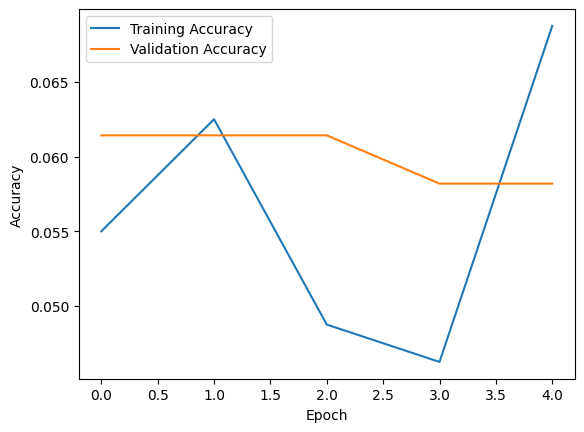

In [17]:
# Optionally, you can plot the training history to visualize the training process
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From the results obtained above, the validation accuracy tends to decrease slightly as the epochs increase. On the other hand, the training accuracy rises upon increasing the number of epochs. This means that, if one needs to increase the training accuracy altering the epoch numbers will be a crucial task.

232/232 [==============================] - 60s 260ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        79
           1       1.00      0.00      0.00         7
           2       1.00      0.00      0.00         6
           3       1.00      0.00      0.00         6
           4       1.00      0.00      0.00       205
           5       1.00      0.00      0.00        25
           6       1.00      0.00      0.00         5
           7       1.00      0.00      0.00        31
           8       1.00      0.00      0.00        25
           9       1.00      0.00      0.00        24
          10       1.00      0.00      0.00        40
          11       1.00      0.00      0.00        13
          12       1.00      0.00      0.00        27
          13       1.00      0.00      0.00        77
          14       1.00      0.00      0.00        66
          15       1.00      0.00      0.00         6


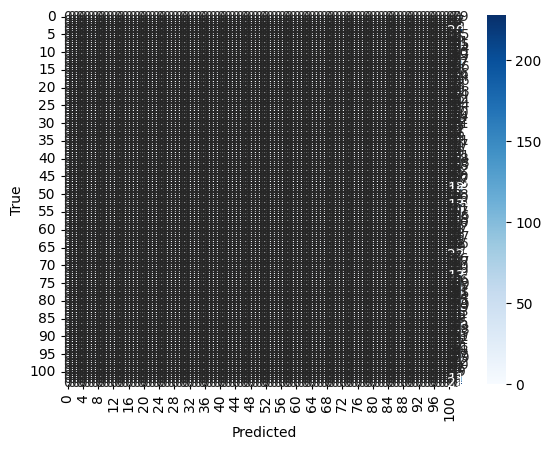

In [18]:
# Having ds_valid as the validation dataset
predictions = model.predict(ds_valid)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in ds_valid], axis=0)

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, zero_division=1))

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# You can use seaborn or matplotlib to plot the confusion matrix
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [19]:
import pandas as pd

def preprocess_test_images(image, label):
    # Resize test images to (224, 224)
    image = tf.image.resize(image, (224, 224))
    # Normalize pixel values to be between 0 and 1
    image = image / 255.0
    return image, label

ds_test_preprocessed = ds_test.map(preprocess_test_images)

# Make predictions on the preprocessed test dataset
test_predictions = model.predict(ds_test_preprocessed)
predicted_test_labels = np.argmax(test_predictions, axis=1)

# Create a DataFrame with the predicted labels
submission_df = pd.DataFrame({
    'ImageId': range(1, len(predicted_test_labels) + 1),  # Assuming ImageId starts from 1
    'Label': predicted_test_labels
})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' has been generated and saved.")

462/462 [==============================] - 133s 287ms/step
Submission file 'submission.csv' has been generated and saved.


# References 

tpu-getting-started,Alexis Cook, Phil Culliton, Ryan Holbrook,Petals to the [Metal - Flower Classification on TPU, Kaggle](https://kaggle.com/competitions/tpu-getting-started)

Alzubaidi, Zhang, Humaidi,Al-Dujaili, Duan, Y., Al-Shamma, Santamaría, Fadhel, Al-Amidie, and Farhan, 2021. Review of deep learning: Concepts, CNN architectures, challenges, applications, future directions. Journal of big Data, 8, pp.1-74.



